This brief notebook is to demonstrate how composition of polynomials can accelerate convergence.

In [6]:
using Plots, LinearAlgebra

chebnodes(N) = [ cos(j*π/N) for j = N:-1:0 ]

function bary(f::Function, N, x)
    X = chebnodes(N)
    F = f.(X)
    return bary(F, x; X=X)
end

function bary(F::Vector, x; X = chebnodes(length(F)-1))
    N = length(F)-1
    p = 0.5 * ( F[1] ./ (x .- X[1]) + (-1)^N * F[N+1] ./(x .- X[N+1]) )
    q = 0.5 * (1.0 ./ (x .- X[1]) + (-1)^N ./ (x .- X[N+1]))
    for n = 1:N-1
        p += (-1)^n * F[n+1] ./ (x .- X[n+1])
        q += (-1)^n ./ (x .- X[n+1])
    end 
    return p ./ q    
end

plotgrid(Np) = range(-1+0.0123, stop=1-0.00321, length=Np)
errgrid(Np) = range(-1+0.0123, stop=1-0.00321, length=Np)



errgrid (generic function with 1 method)

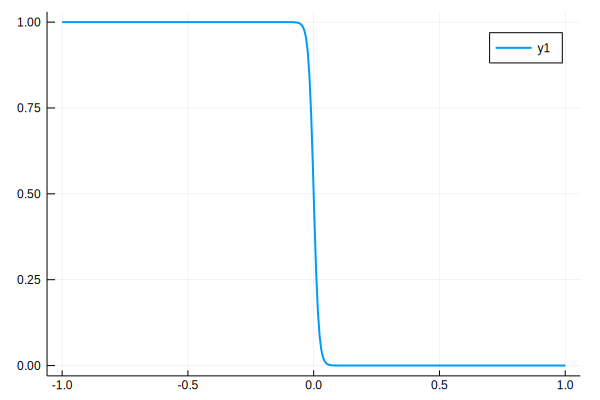

In [2]:
f(β, x) = 1 / (1 + exp(β*x))
β = 100
xp = range(-1, stop=1, length=300)
plot(xp, f.(β, xp), lw=2)

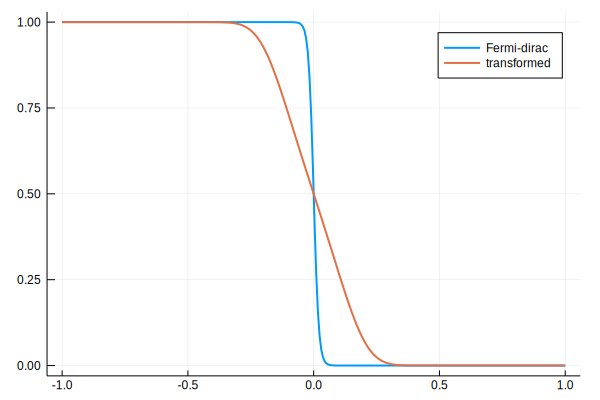

In [3]:
f(β, x) = 1 / (1 + exp(β*x))
β = 100
f(x) = f(β, x)
Y(x) = (0.1*x + x^3) / 1.1
g(x) = f(Y(x))
xp = range(-1, stop=1, length=300)
plot(xp, f.(β, xp), lw=2, label="Fermi-dirac")
plot!(xp, g.(xp), lw=2, label="transformed")

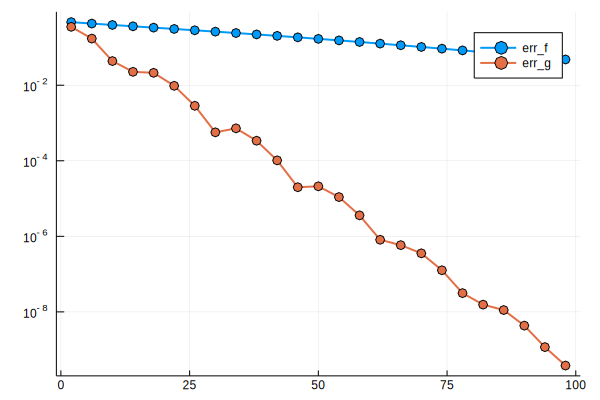

In [7]:
xp = errgrid(1000)
NN = 2:4:100
err_f = [ norm(f.(xp) - bary(f, N, xp), Inf) for N = NN]
err_g = [ norm(g.(xp) - bary(g, N, xp), Inf) for N = NN]
# pred = 1.5*exp.(-NN/5)
plot(NN, [err_f, err_g], lw=2, m=:o, 
    label=["err_f", "err_g"], yaxis = (:log,))

The idea is we can first approximate $g_\beta(x) \approx p(x)$ and then evaluate $f_\beta(x) \approx p(Y^{-1}(x))$. This is fine as long as we have a cheap way to compute $Y^{-1}(x)$. But this involves roots which are just as difficult, if not more difficult to evaluate than $f_\beta$! The solution is to create a crude polynomial approximation to $Y^{-1}$. Or, alternatively, we can specify $Y^{1}$ directly first.  

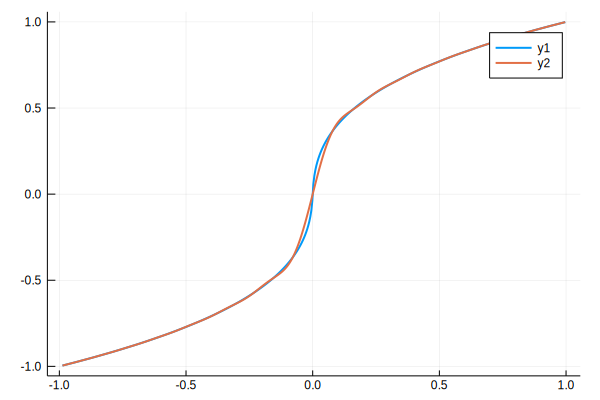

In [8]:
# R(x) represents Y^{-1}(x)
epsn = 0.001
R(x) = sign(x)*((abs(x)+epsn)^(1/3) - epsn^(1/3)) / ((1+epsn)^(1/3) - epsn^(1/3))
xx = plotgrid(500)
# and p_xx is a polynomial approximation to Y^{-1}!
p_xx = bary(R, 40, xx)
plot(xx, [R.(xx), p_xx], lw = 2)

In [9]:
# now we need to invert R(x) to get R^{-1}(x) ~ Y(x)
using Roots
RR = R.(chebnodes(40))
pp(x) = bary(RR, x)
pp_inv(y) = (abs(y) == 1.0 ? y : 
             fzero(x -> pp(x) - y, y^3, xatol = 1e-10))

pp_inv (generic function with 1 method)

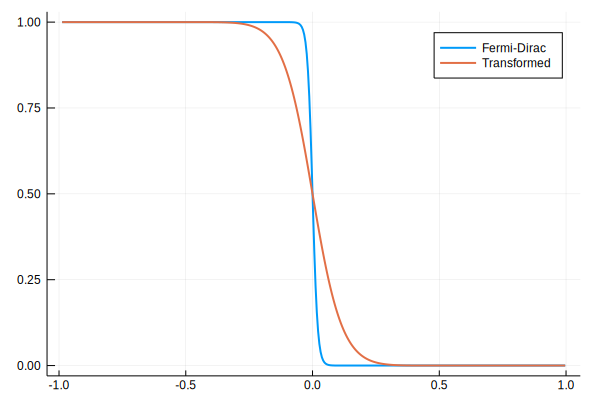

In [10]:
β = 100
f(x) = 1 / (1 + exp(β*x))
g(x) = f(pp_inv(x))
xx = plotgrid(400)
plot(xx, [f.(xx), g.(xx)], lw=2, label=["Fermi-Dirac", "Transformed"])

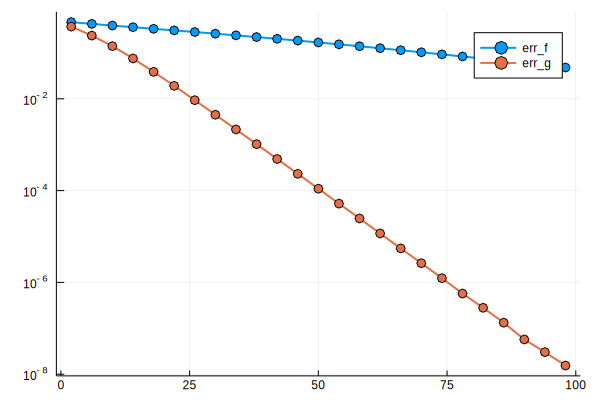

In [11]:
## ERROR TEST 
xp = errgrid(1000)
NN = 2:4:100
err_f = [ norm(f.(xp) - bary(f, N, xp), Inf) for N = NN]
err_g = [ norm(g.(xp) - bary(g, N, xp), Inf) for N = NN]
# pred = 1.5*exp.(-NN/5)
plot(NN, [err_f, err_g], lw=2, m=:o, 
    label=["err_f", "err_g"], yaxis = (:log,))